<a href="https://colab.research.google.com/github/sayan0506/HardHead-Detection-for-Safety-Surveilance-using-YoloV3/blob/main/Personal_Safety_Equipment_Detection_System_using_YoloV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implement YoloV3 based Safety Equipment Detection using Tensorflow**

• **Task: Build A Personal Safety Equipment Detection System**

In this noteboook we will try to build a Helmet Detection system from real time images in contruction sites as a personal safety system. The system should detect either head or helmet independently from the images. YoloV3(You Only Look Once Version 3) is an efficient model which has darknet as it's backbone, will be used here to efficiently and fast detect and process the images/video-frame in real time scenarios.

## **Install Dependencies**

In [1]:
# install tensorflow gpu
!pip install tensorflow-gpu==2.4.2

# install opencv = 4.1.1.26
!pip install opencv-python==4.1.1.26

# install lxml(helps to parse xml annotations)
!pip install lxml

# install tqdm(it helps to visualize the progress bar while iterating a loop)
# it adds a smart progress meter in loop execution
!pip install tqdm

     |████████████████████████████████| 394.5 MB 33 kB/s 
     |████████████████████████████████| 2.9 MB 62.9 MB/s 
     |████████████████████████████████| 462 kB 59.0 MB/s 
     |████████████████████████████████| 3.8 MB 57.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

## **Import Dependencies**

In [2]:
import zipfile
import os
import random
import numpy as np
from absl import logging
from absl.flags import FLAGS

import time
#hashlib helps to encypt the data so that data does not get changes while parsing
import hashlib

import lxml.etree # to process xml tree structure in Pascal Voc annot files
import tqdm

from IPython.display import Image
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

#flags can be used to define or initialize the configuration variable throughout the pipeline
from absl import app, flags, logging

#from .utils import broadcast_iou

## **Mount Drive**

Drive mail_id: hazrasayan2020@gmail.com

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## **Environment Setup**

**Improve Reproducibility**

In [4]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETEREMINISTIC'] = '1'
random.seed(hash('setting random seeds') % 2**32 -1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash('by removing stochasticity')% 2**32 -1)

**GPU Utilization**

In [5]:
# system setup 
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18429012253441477788, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14646682624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16283330065360818929
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [6]:
# checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at {device}')

Found GPU at /device:GPU:0


## **Dataset Load**

Load the HardHat Dataset zip from drive folder

zip_path : "/content/drive/MyDrive/HardHead Dataset/HardHat_Dataset.zip"

**Define unzipping function**

In [7]:
def unzipping(src, dst):
  if not os.path.isdir(dst):
    os.mkdir(dst) # unzip path

  # unzipping to dst
  with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall(dst)

unzip the dataset zip file

In [8]:
zip_path = '/content/drive/MyDrive/HardHead_Dataset/HardHat_Dataset.zip'
dataset_path = 'Hardhat_dataset'

# unzip
unzipping(zip_path, dataset_path)

## **Data Preperation**

Define class dictionary

In [9]:
classifiers = ['helmet', 'head']

id_list = [i for i in range(len(classifiers))]

class_dict = dict(zip(classifiers, id_list))

print(f'Class dictionary for hardhead dataset {class_dict}')

Class dictionary for hardhead dataset {'helmet': 0, 'head': 1}


**Write classes.names text file to store the class list**

In [10]:
labels_str = '\n'.join(sorted(class_dict.keys()))
drive_path = '/content/drive/MyDrive/HardHead_Dataset/' 

# class file path(.names is a text file to store the object labels)
class_path = os.path.join(drive_path, 'hardhat_classes.names')

with open(class_path, 'w') as f:
 f.write(labels_str)

**Write image_names.txt file to store the image names present in the dataset**

In [11]:
img_list = os.listdir(os.path.join(dataset_path, 'images'))
annot_list = os.listdir(os.path.join(dataset_path, 'annotations'))

# verify lenght with annotation lenghts
assert len(img_list) == len(annot_list)
print(f'Total image samples in the dataset {len(img_list)}')

img_file_path = os.path.join(drive_path, 'hardhat_image_names.txt')
img_id_list = [id for id,_ in enumerate(img_list)]
img_names = [img.split('.')[0] for img in img_list]
print(f'Sample image  name: {img_names[0]}')

img_dict = dict(zip(img_names, img_id_list))

imgs_str = '\n'.join(sorted(img_dict.keys()))

# image names file path
with open(img_file_path, 'w') as f:
 f.write(imgs_str)

Total image samples in the dataset 4750
Sample image  name: hard_hat_workers2117


#### **Prepare TfRecords**

**Function to build the tf-records from annotaion files and images**

In [12]:
def build_example(data_dir, annotation, class_map):
    img_path = os.path.join(
        data_dir, 'images', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    # encrypt images
    key = hashlib.sha256(img_raw).hexdigest()

    width = int(annotation['size']['width'])
    height = int(annotation['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            if obj['name'] in class_map:
              difficult = bool(int(obj['difficult']))
              difficult_obj.append(int(difficult))

              xmin.append(float(obj['bndbox']['xmin']) / width)
              ymin.append(float(obj['bndbox']['ymin']) / height)
              xmax.append(float(obj['bndbox']['xmax']) / width)
              ymax.append(float(obj['bndbox']['ymax']) / height)
              classes_text.append(obj['name'].encode('utf8'))
              classes.append(class_map[obj['name']])
              truncated.append(int(obj['truncated']))
              views.append(obj['pose'].encode('utf8'))
            
            #else:
              #print('Object class {0} is skipped'.format(obj['name']))
            #  continue

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


**Define function to parse xml annotations**

In [13]:
def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

**Class map**

In [14]:
class_map = {name: idx for idx, name in enumerate(
    open(class_path).read().splitlines())}
print(f'Class mapping loaded: {class_map}')

Class mapping loaded: {'head': 0, 'helmet': 1}


**Fetch image list**

In [15]:
image_list = open(img_file_path).read().splitlines()
print("Image list loaded: ", len(image_list))

Image list loaded:  4750


**Split train and validation data with split_ratio = [0.95:0.05]**

In [16]:
# train, valid split
train_imgs, valid_imgs, train_annots, valid_annots = train_test_split(img_names, annot_list,
                                                                      test_size = 0.05,
                                                                      shuffle = True)

assert len(train_imgs) == len(train_annots)
assert len(valid_imgs) == len(valid_annots)

print(f'Total training smaples {len(train_imgs)}')
print(f'Total validation smaples {len(valid_imgs)}')

Total training smaples 4512
Total validation smaples 238


#### **Create Tfrecords**

TFrecords metadata

In [17]:
# max bounding boxes in the image
max_bbox = 100

**Create TrainTfrecords**

Define functions to tfrecord creation steps

In [18]:
def tfrecord_steps(image_list, tfrecord_path):
  # writer object
  writer = tf.io.TFRecordWriter(tfrecord_path)

  for name in tqdm.tqdm(image_list):
    annotation_xml = os.path.join(dataset_path, 'annotations', name + '.xml')
    # read annotation files
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    # parse the annotation xml
    annotation = parse_xml(annotation_xml)['annotation']
    #print(annotation)
    # build tfrecords
    tf_example = build_example(dataset_path, annotation, class_map)
    writer.write(tf_example.SerializeToString())

  writer.close()
  print('Tfrecord conversion is Done!\n')

Create train and valid record

In [19]:
# define tfrecords metadata train
train_record = os.path.join(drive_path, 'hardhat_train.tfrecord')
tfrecord_steps(train_imgs, train_record)

# define tfrecords metadata valid
valid_record = os.path.join(drive_path, 'hardhat_valid.tfrecord')
tfrecord_steps(valid_imgs, valid_record)

100%|██████████| 4512/4512 [00:17<00:00, 265.10it/s]


Tfrecord conversion is Done!



100%|██████████| 238/238 [00:00<00:00, 413.91it/s]

Tfrecord conversion is Done!



#### **Load TfRceords**

In [20]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md#conversion-script-outline-conversion-script-outline
# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}

In [21]:
def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, max_bbox - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train

In [22]:
def load_tfrecord_dataset(file_pattern, class_file, size = 416):
  # line number
  LINE_NUMBER = tf.lookup.TextFileIndex.LINE_NUMBER
  class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
      class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter = "\n"), -1)
  
  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

**Visualize TfRecord**

Visualize the sample tfrecord

In [23]:
# draw results on outputs
def draw_outputs(img, outputs, class_names):
    #print(class_names)
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    #print(classes)
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [24]:
# load class names
class_names = open(class_path).read().split('\n')
print(f'Class names loaded for visualization- {class_names}')

# load the train tefrecord
tfrecord_train_path = os.path.join(drive_path, 'hardhat_train.tfrecord')
dataset = load_tfrecord_dataset(tfrecord_train_path, class_path, 416)

Class names loaded for visualization- ['head', 'helmet']


Total object fiels in the image 100
Total objects in the image 7


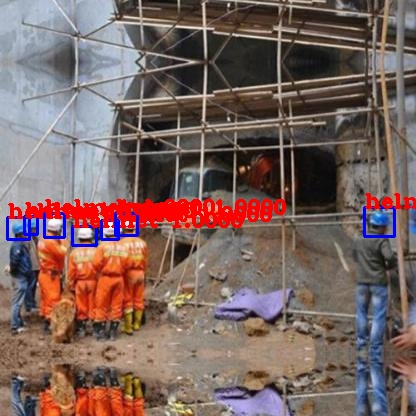

In [46]:
# shufle the dataset with buffer size 512
dataset = dataset.shuffle(512)

# traverse through the images(pass single image for visualization)
for image, labels in dataset.take(1):
    print(f'Total object fiels in the image {len(labels)}') # it defines each image can contain 20 objects
    # so the labels return the 20 possibilities in the image
    boxes = [] # list that stores box infos for each image
    scores = [] # object prediction scores
    classes = [] # classes list of objects
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]
    print(f'Total objects in the image {nums[0]}')
    #print(classes)
    logging.info('labels:')
    
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                            np.array(scores[0][i]),
                                            np.array(boxes[0][i])))

    
    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite('new.jpg', img)
    #logging.info('output saved to: {}'.format(FLAGS.output))

Image(filename = '/content/new.jpg')

In [47]:
classes

[[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0>]]

## **Model Building and Load Pre-trained weights**

Load YoloV3 pretrained weights

In [26]:
# create model folder in drive path
model_path = os.path.join(drive_path, 'models')

if not os.path.isdir(model_path):
  os.mkdir(model_path)

# download yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights -O /content/drive/MyDrive/HardHead_Dataset/models/yolov3.weights

--2021-08-14 22:13:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/HardHead_Dataset/models/yolov3.weights’

/content/drive/MyDr 100%[===================>] 236.52M  63.9MB/s    in 3.7s    

2021-08-14 22:13:45 (63.9 MB/s) - ‘/content/drive/MyDrive/HardHead_Dataset/models/yolov3.weights’ saved [248007048/248007048]



#### **Convert Pre-trained Darknet Weight**

**Define Darknet Model and it's components(as Darknet Used as YoloV3 Backend**

In [27]:
# define Darknet Convolution layer(Darknet used as Yolov3 backend)
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

# Define Draknet Residual layer
def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

# Define Darknet Block
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x


# Define Darknet Model
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

**Define YoloV3 Model**


In [28]:
'''
Define metadata for YoloV3
'''
#define different Yolo anchors
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416

# Yolo anchor masks
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

# define yolo max boxes
yolo_max_boxes = 100
# yolo_iou_threshold
yolo_iou_threshold = 0.5
# yolo score threshold
yolo_score_threshold = 0.5

YoloV3 Function Definition

In [29]:
# define YoloConvolution layer
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

# Define Yolo output
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

# As tensorflow lite doesn't support tf.size used in tf.meshgrid, 
# we reimplemented a simple meshgrid function that use basic tf function.
def _meshgrid(n_a, n_b):

    return [
        tf.reshape(tf.tile(tf.range(n_a), [n_b]), (n_b, n_a)),
        tf.reshape(tf.repeat(tf.range(n_b), n_a), (n_b, n_a))
    ]

# Define yoloboxes block
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = _meshgrid(grid_size[1],grid_size[0])
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

# Define Yolo Non Max Suppression function
def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs

    dscores = tf.squeeze(scores, axis=0)
    scores = tf.reduce_max(dscores,[1])
    bbox = tf.reshape(bbox,(-1,4))
    classes = tf.argmax(dscores,1)
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        boxes=bbox,
        scores=scores,
        max_output_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold,
        soft_nms_sigma=0.5
    )
    
    num_valid_nms_boxes = tf.shape(selected_indices)[0]

    selected_indices = tf.concat([selected_indices,tf.zeros(yolo_max_boxes-num_valid_nms_boxes, tf.int32)], 0)
    selected_scores = tf.concat([selected_scores,tf.zeros(yolo_max_boxes-num_valid_nms_boxes,tf.float32)], -1)

    boxes=tf.gather(bbox, selected_indices)
    boxes = tf.expand_dims(boxes, axis=0)
    scores=selected_scores
    scores = tf.expand_dims(scores, axis=0)
    classes = tf.gather(classes,selected_indices)
    classes = tf.expand_dims(classes, axis=0)
    valid_detections=num_valid_nms_boxes
    valid_detections = tf.expand_dims(valid_detections, axis=0)

    return boxes, scores, classes, valid_detections

# Define YoloV3 model
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

Define function to load Yolo model

In [30]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

def load_darknet_weights(model, weights_file, tiny=False):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    if tiny:
        layers = YOLOV3_TINY_LAYER_LIST
    else:
        layers = YOLOV3_LAYER_LIST

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()


**Load YoloV3 Model**

In [31]:
#variable to get the physical devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# define yolo object
#yolo = YoloV3(classes = len(classifiers))
yolo = YoloV3(classes = 80)
# model summary
yolo.summary()

load_darknet_weights(yolo, '/content/drive/MyDrive/HardHead_Dataset/models/yolov3.weights', False)

img = np.random.random((1, 320, 320, 3)).astype(np.float32)
output = yolo(img)
print('sanity check passed')

weight_tf_file = '/content/drive/MyDrive/HardHead_Dataset/models/yolov3.tf'
yolo.save_weights(weight_tf_file)
print(f'Weights conversion done to - {weight_tf_file}')

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

## **Model Training**

**Define the variables to initialize the training**

In [32]:
# Guides

'''
flags.DEFINE_string('dataset', '', 'path to dataset')
flags.DEFINE_string('val_dataset', '', 'path to validation dataset')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_enum('mode', 'fit', ['fit', 'eager_fit', 'eager_tf'],
                  'fit: model.fit, '
                  'eager_fit: model.fit(run_eagerly=True), '
                  'eager_tf: custom GradientTape')
flags.DEFINE_enum('transfer', 'none',
                  ['none', 'darknet', 'no_output', 'frozen', 'fine_tune'],
                  'none: Training from scratch, '
                  'darknet: Transfer darknet, '
                  'no_output: Transfer all but output, '
                  'frozen: Transfer and freeze all, '
                  'fine_tune: Transfer all and freeze darknet only')
flags.DEFINE_integer('size', 416, 'image size')
flags.DEFINE_integer('epochs', 2, 'number of epochs')
flags.DEFINE_integer('batch_size', 8, 'batch size')
flags.DEFINE_float('learning_rate', 1e-3, 'learning rate')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
flags.DEFINE_integer('weights_num_classes', None, 'specify num class for `weights` file if different, '
                     'useful in transfer learning with different number of classes')
flags.DEFINE_boolean('multi_gpu', False, 'Use if wishing to train with more than 1 GPU.')
'''
# image dimension
image_size = 416
# num of classes for the dataset
num_classes = 2
# status of transfer learning
transfer = 'darknet'
# specify num class for `weights` file if different,
#useful in transfer learning with different number of classes
weights_num_classes = 80
# weights file path
weights = '/content/drive/MyDrive/HardHead_Dataset/models/yolov3.tf'
# define learning rate
learning_rate = 1e-03
#'mode', 'fit', ['fit', 'eager_fit', 'eager_tf'],
#                  'fit: model.fit, '
#                  'eager_fit: model.fit(run_eagerly=True), '
#                  'eager_tf: custom GradientTape')
# further info on mode can be found from eager execution url - https://www.tensorflow.org/guide/eager
mode = 'fit'
#Use if wishing to train with more than 1 GPU.
multi_gpu = False
# batch size
batch_size = 16
# epochs
epochs = 10

**Function to transform images & targets**

In [33]:
# transform images
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

# transform targets for output
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x1, y1, x2, y2, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


# transform targets
def transform_targets(y_train, anchors, anchor_masks, size):
    y_outs = []
    grid_size = size // 32

    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs))
        grid_size *= 2

    return tuple(y_outs)

**Define function freeze the model layers for transfer learning purpose**

In [34]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

**Yolo Loss function**

In [35]:
# boroadcast iou
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)


# yolo loss
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

**Define Model Setup function**

In [36]:
def setup_model():
    '''
    if FLAGS.tiny:
        model = YoloV3Tiny(FLAGS.size, training=True,
                           classes=FLAGS.num_classes)
        anchors = yolo_tiny_anchors
        anchor_masks = yolo_tiny_anchor_masks
    else:
    '''
    model = YoloV3(image_size, training=True, classes=num_classes)
    anchors = yolo_anchors
    anchor_masks = yolo_anchor_masks

    # Configure the model for transfer learning
    if transfer == 'none':
        pass  # Nothing to do
    elif transfer in ['darknet', 'no_output']:
        # Darknet transfer is a special case that works
        # with incompatible number of classes
        # reset top layers
        #if FLAGS.tiny:
        #    model_pretrained = YoloV3Tiny(
        #        FLAGS.size, training=True, classes=FLAGS.weights_num_classes or FLAGS.num_classes)
        #else:
        model_pretrained = YoloV3(
            image_size, training=True, classes=weights_num_classes or num_classes)
        model_pretrained.load_weights(weights)

        if transfer == 'darknet':
            model.get_layer('yolo_darknet').set_weights(
                model_pretrained.get_layer('yolo_darknet').get_weights())
            freeze_all(model.get_layer('yolo_darknet'))
        elif transfer == 'no_output':
            for l in model.layers:
                if not l.name.startswith('yolo_output'):
                    l.set_weights(model_pretrained.get_layer(
                        l.name).get_weights())
                    freeze_all(l)
    else:
        # All other transfer require matching classes
        model.load_weights(weights)
        if FLAGS.transfer == 'fine_tune':
            # freeze darknet and fine tune other layers
            darknet = model.get_layer('yolo_darknet')
            freeze_all(darknet)
        elif transfer == 'frozen':
            # freeze everything
            freeze_all(model)

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = [YoloLoss(anchors[mask], classes=num_classes)
            for mask in anchor_masks]

    model.compile(optimizer=optimizer, loss=loss,
                  run_eagerly=(mode == 'eager_fit'))

    return model, optimizer, loss, anchors, anchor_masks

#### **Model Training**

In [78]:
#!usr/bin/env python3 
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Setup
if multi_gpu:
    for physical_device in physical_devices:
        tf.config.experimental.set_memory_growth(physical_device, True)

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    BATCH_SIZE = batch_size * strategy.num_replicas_in_sync
    batch_size = BATCH_SIZE

    with strategy.scope():
        model, optimizer, loss, anchors, anchor_masks = setup_model()
else:
    model, optimizer, loss, anchors, anchor_masks = setup_model()

# dataset setup
## train set
train_dataset = load_tfrecord_dataset(
    train_record, class_path, image_size)
train_dataset = train_dataset.shuffle(buffer_size=512)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(lambda x, y: (
    transform_images(x, image_size),
    transform_targets(y, anchors, anchor_masks, image_size)))
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

## validation set
val_dataset = load_tfrecord_dataset(
            valid_record, class_path, image_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (
    transform_images(x, image_size),
    transform_targets(y, anchors, anchor_masks, image_size)))

# training loop
if mode == 'eager_tf':
    # Eager mode is great for debugging
    # Non eager graph mode is recommended for real training
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

    for epoch in range(1, FLAGS.epochs + 1):
        for batch, (images, labels) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                outputs = model(images, training=True)
                regularization_loss = tf.reduce_sum(model.losses)
                pred_loss = []
                for output, label, loss_fn in zip(outputs, labels, loss):
                    pred_loss.append(loss_fn(label, output))
                total_loss = tf.reduce_sum(pred_loss) + regularization_loss

            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(
                zip(grads, model.trainable_variables))

            logging.info("{}_train_{}, {}, {}".format(
                epoch, batch, total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss))))
            avg_loss.update_state(total_loss)

        for batch, (images, labels) in enumerate(val_dataset):
            outputs = model(images)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

            logging.info("{}_val_{}, {}, {}".format(
                epoch, batch, total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss))))
            avg_val_loss.update_state(total_loss)

        logging.info("{}, train: {}, val: {}".format(
            epoch,
            avg_loss.result().numpy(),
            avg_val_loss.result().numpy()))

        avg_loss.reset_states()
        avg_val_loss.reset_states()
        model.save_weights(
            'checkpoints/yolov3_train_{}.tf'.format(epoch))

else:
    callbacks = [
        ReduceLROnPlateau(verbose=1),
        EarlyStopping(patience=3, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/HardHead_Dataset/checkpoints/yolov3_train_{epoch}.tf',
                        verbose=1, save_weights_only=True),
        TensorBoard(log_dir='logs')
    ]

    start_time = time.time()
    history = model.fit(train_dataset,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=val_dataset)
    end_time = time.time() - start_time
    print(f'Total Training Time: {end_time}')


ValueError: ignored

In [66]:
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

In [67]:
model.save_weights('yolov3.tf')

In [75]:
def detect_img(path):
  num_classes = 2
  classes = class_dict
  weights = '/content/yolov3.tf'

  # Lower threshold due to insufficient training
  yolo_iou_threshold = 0.2
  yolo_score_threshold = 0.2

  #if FLAGS.tiny:
  #    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  #else:
  yolo = YoloV3(classes=num_classes)

  yolo.load_weights(weights).expect_partial()
  logging.info('weights loaded')

  #class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  #logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(image_demo, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, image_size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  #logging.info('time: {}'.format(t2 - t1))

  #logging.info('detections:')


  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  from IPython.display import Image, display
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))


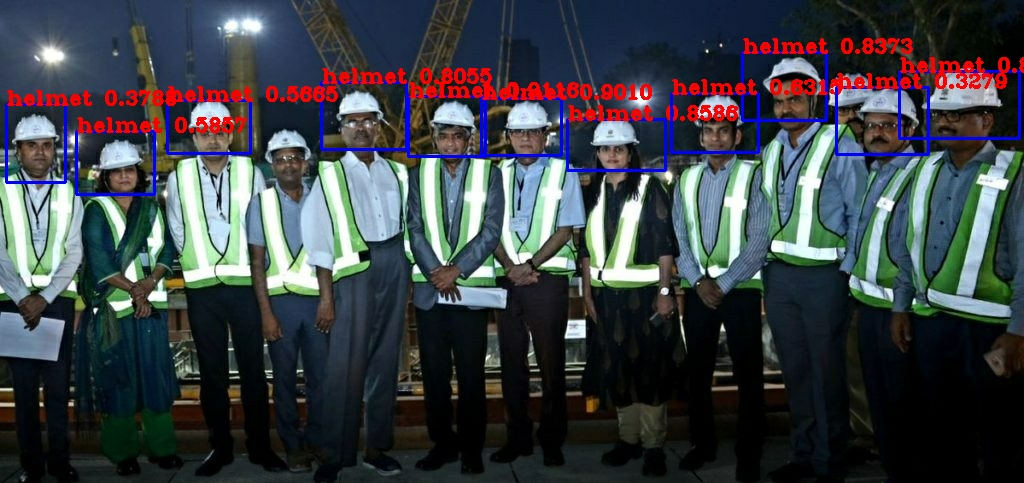

In [76]:
image_demo = '/content/00000.jpg'
detect_img(image_demo)

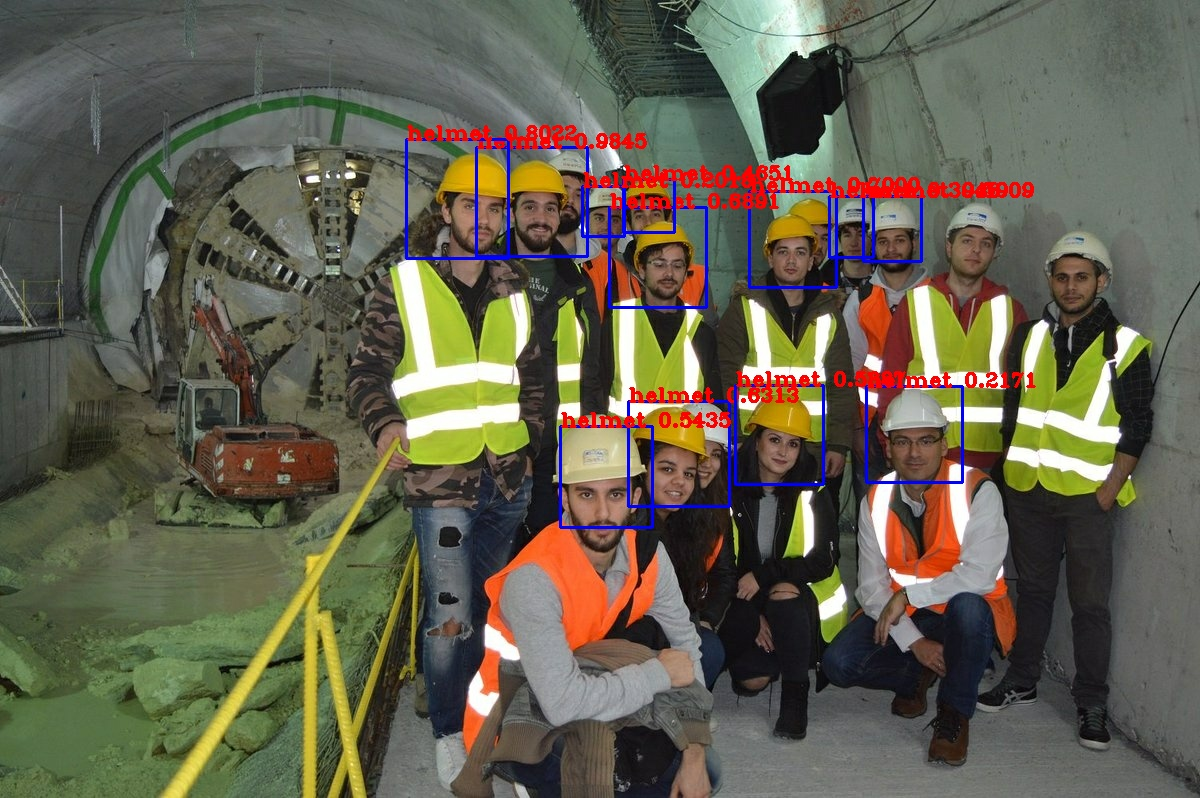

In [77]:
image_demo = '/content/00005.jpg'
detect_img(image_demo)